<h1 style="text-align: center;">CS 6476 - Computer Vision </h1>
<h2 style="text-align: center;">Problem Set 2 - Window-based Stereo Matching</h2>

In [6]:
import cv2 
import numpy as np 
import copy as cp
from PIL import Image
import matplotlib.pyplot as plt
import sys
import multiprocessing
from functools import partial
from multiprocessing import Pool

### Question 1 :

In [7]:



def my_ssd_match(px,py,R,L,size,disparity):
    minx = max(px-disparity,size//2)
    maxx = min(R.shape[1]-size//2,px+disparity)
    template = L[py-size//2:py+size//2,px-size//2:px+size//2].astype(np.float32)
    # Could delete this line to gain some speed
    cost = np.array([(np.square(np.subtract(R[py-size//2:py+size//2,x-size//2:x+size//2].astype(np.float32)
                                                        ,template))).sum().astype(np.float32) for x in np.arange(minx,maxx)])
    return np.abs(px -(np.argmin(cost) +minx))

def cv_corr_match(px,py,R,L,size,disparity):
    minx = max(px-disparity,size//2)
    maxx = min(R.shape[1]-size//2,px+disparity)
    template = L[py-size//2:py+size//2,px-size//2:px+size//2].astype(np.float32)
    
    return np.abs(px-(np.argmax(cv2.matchTemplate(R[py-size//2:py+size//2,minx-size//2:maxx+size//2].astype(np.float32),template,
                                          cv2.TM_CCOEFF_NORMED))+minx))
    
def my_format(im, bs):
    new_im = cp.deepcopy(im)
    new_im = cv2.normalize(new_im,new_im,0,255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return new_im[bs//2:new_im.shape[0]-bs//2,bs//2:new_im.shape[1]-bs//2]


def disparity(L_im, R_im, size = 11,disparity=30,matching='ssd'):

    L = L_im
    R = R_im
    D = np.zeros(L_im.shape,dtype=np.float32)
    for i in np.arange(size//2,L.shape[0]-size//2):
        if(i%100==0):
            print('row : ',i)
        for j in np.arange(size//2,R.shape[1]-size//2):
            if(matching=='ssd'):
                D[i,j] = my_ssd_match(j,i,R,L,size,disparity)
            else:
                D[i,j] = cv_corr_match(j,i,R,L,size,disparity)
    print('process done')
    return D

# Does not work
def fast_disparity(L_im, R_im, size = 11,disparity=30,matching='ssd',processes=8):
    
    L = L_im
    R = R_im
    if(matching=='ssd'):
        disp_func = partial(my_ssd_match,R=R,L=L,size=size,disparity=disparity)
    else:
        disp_func = partial(cv_corr_match,R=R,L=L,size=size,disparity=disparity)
    pool = Pool(processes=processes)
    D = pool.map(disp_func,[(px,py) for px in np.arange(L.shape[1]) for py in np.arange(R.shape[0])])
    pool.close()
    pool.join()
    
    D = np.array(D,dtype=np.float32).reshape(L.shape)
return D


In [69]:
%%time
im_r_1 = cv2.imread('./Data/rightTest.png')
im_l_1 = cv2.imread('./Data/leftTest.png')

im_gray_r_1 = cp.deepcopy(im_r_1)
im_gray_l_1 = cp.deepcopy(im_l_1)
size1 = 11
size2=15
dl = disparity(im_gray_l_1,im_gray_r_1,size=size1,disparity = 2)
dr = disparity(im_gray_r_1,im_gray_l_1,size=size2,disparity= 3)

row :  100
process done
row :  100
process done
Wall time: 1.92 s


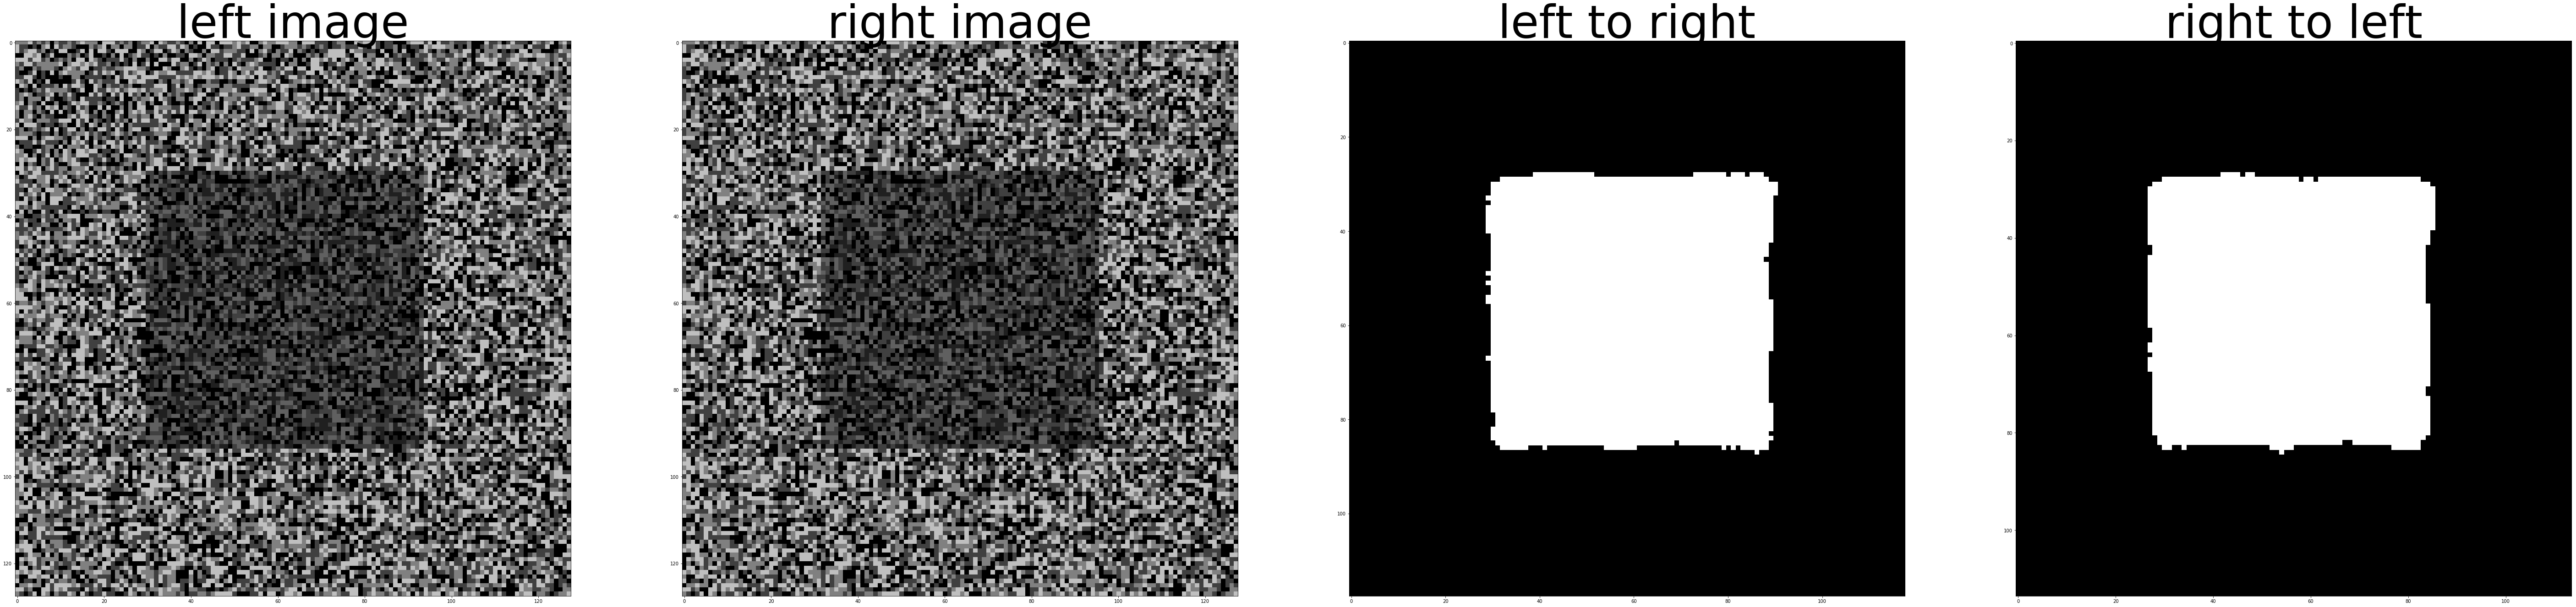

Wall time: 3.44 s


In [71]:
%%time

dl_edit = my_format(dl,size1)
dr_edit = my_format(dr,size2)

cv2.imwrite('ps2-1-a-0.jpg',dl_edit)
cv2.imwrite('ps2-1-a-1.jpg',dr_edit)

plt.figure(figsize=(100,100))
plt.subplot(1,4,1),plt.imshow(im_r_1,cmap='gray'),plt.title('left image',fontsize=100)
plt.subplot(1,4,2),plt.imshow(im_l_1,cmap='gray'),plt.title('right image',fontsize=100)
plt.subplot(1,4,3),plt.imshow(dl_edit,cmap='gray'),plt.title('left to right',fontsize=100)
plt.subplot(1,4,4),plt.imshow(dr_edit,cmap='gray'),plt.title('right to left',fontsize=100)
plt.show()



### Question 2 :

In [10]:
%%time
im_2_l = cv2.imread('./Data/proj2-pair1-L.png',0)
im_2_r = cv2.imread('./Data/proj2-pair1-R.png',0)

size3 = 10

dl2 = disparity(im_2_l,im_2_r,size=size3,disparity = 100)
dr2 = disparity(im_2_r,im_2_l,size=size3,disparity = 100)

row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
Wall time: 14min 13s


In [11]:
dl2_edit = my_format(dl2,size3)
dr2_edit = my_format(dr2,size3)


d_2_l_real = cv2.imread('./Data/proj2-pair1-Disp-L.png',0)
d_2_r_real = cv2.imread('./Data/proj2-pair1-Disp-L.png',0)

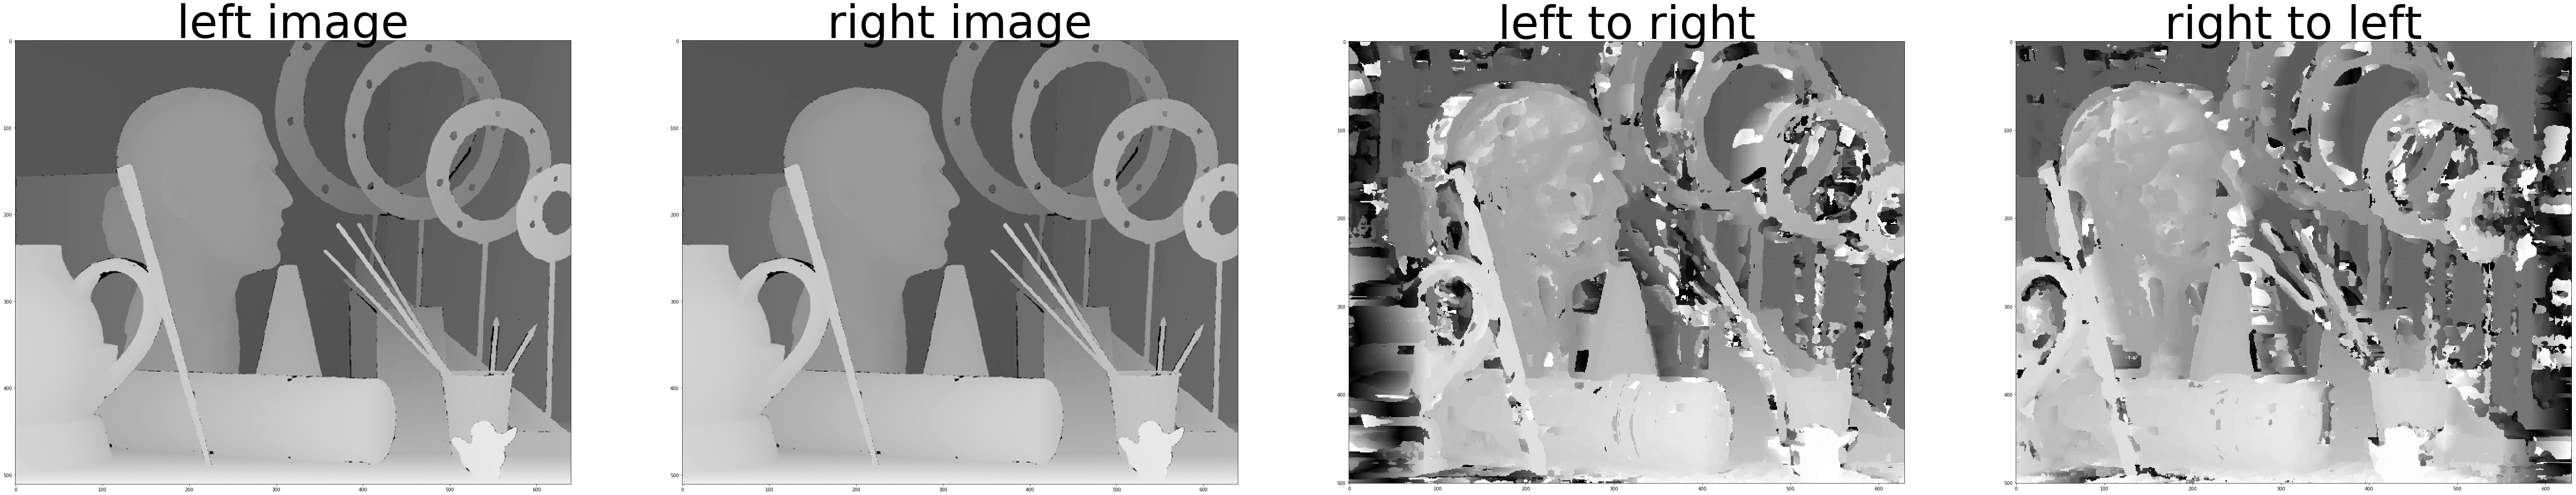

In [72]:
cv2.imwrite('ps2-2-a-0.jpg',dl2_edit)
cv2.imwrite('ps2-2-a-1.jpg',dr2_edit)

plt.figure(figsize=(100,100))
plt.subplot(1,4,1),plt.imshow(d_2_l_real,cmap='gray'),plt.title('left image',fontsize=100)
plt.subplot(1,4,2),plt.imshow(d_2_r_real,cmap='gray'),plt.title('right image',fontsize=100)
plt.subplot(1,4,3),plt.imshow(dl2_edit,cmap='gray'),plt.title('left to right',fontsize=100)
plt.subplot(1,4,4),plt.imshow(dr2_edit,cmap='gray'),plt.title('right to left',fontsize=100)
plt.show()

The disparity is inaccurate on thin or small objects like the iron bars. However, the overal result is quite close from the reality. The good maximu disparity seems to be around 100 px.

### Question 3 :

#### a)

In [13]:
im_3_l = cv2.imread('./Data/rightTest.png',0)
im_3_r = cv2.imread('./Data/leftTest.png',0)

im_3_l_2 = cv2.imread('./Data/proj2-pair1-L.png',0)
im_3_r_2 = cv2.imread('./Data/proj2-pair1-R.png',0)




def addNoise(im):
    im = cp.deepcopy(im)
    gauss = np.random.normal(0,10,(im.shape[0],im.shape[1]))
    gauss = gauss.reshape(im.shape[0],im.shape[1])
    return im+gauss

def addContrast(im,alpha = 0.1):
    im = cp.deepcopy(im)
    return (1+alpha)*im
    


im_noise_l = addNoise(im_3_l_2)
im_noise_r = addNoise(im_3_r_2)


In [14]:
%%time

dl3 = disparity(im_3_l_2,im_noise_r,11,100)
dr3= disparity(im_3_r_2,im_noise_l,11,100)
dl3_2 = disparity(im_noise_r,im_noise_l,11,120)
dr3_2 = disparity(im_noise_l,im_noise_r,11,120)


row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
Wall time: 32min 20s


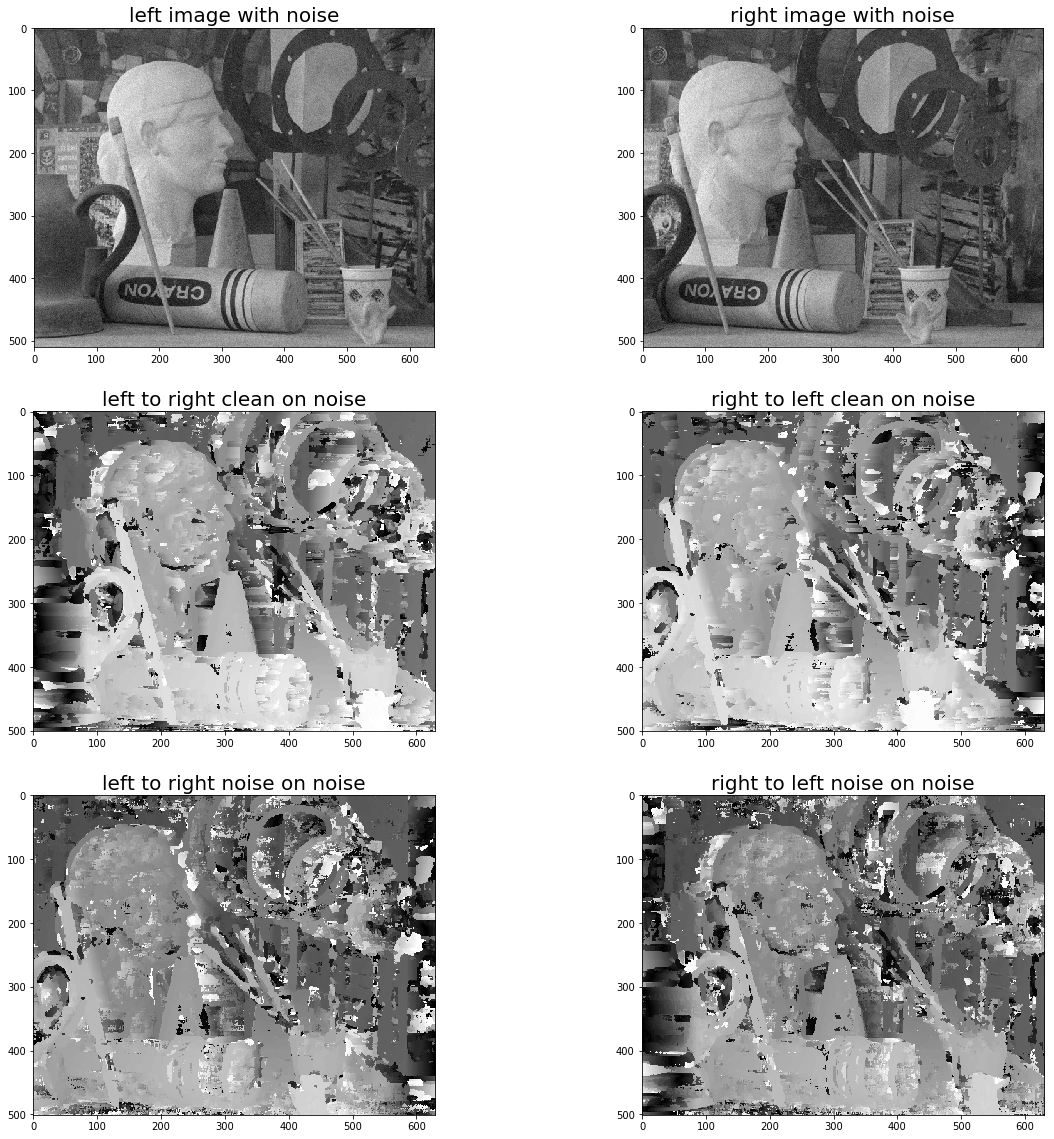

In [68]:
dl3_edit = my_format(dl3,11)

cv2.imwrite('ps2-3-a-0.jpg',dl3_edit)

dr3_edit = my_format(dr3,11)

cv2.imwrite('ps2-3-a-1.jpg',dr3_edit)

dr3_2_edit = my_format(dr3_2,11)

cv2.imwrite('ps2-3-a-3.jpg',dr3_2_edit)

dl3_2_edit = my_format(dl3_2,11)


cv2.imwrite('ps2-3-a-2.jpg',dl3_2_edit)


plt.figure(figsize=(20,20))
plt.subplot(3,2,1),plt.imshow(im_noise_l,cmap='gray'),plt.title('left image with noise',fontsize=20)
plt.subplot(3,2,2),plt.imshow(im_noise_r,cmap='gray'),plt.title('right image with noise',fontsize=20)
plt.subplot(3,2,3),plt.imshow(dl3_edit,cmap='gray'),plt.title('left to right clean on noise',fontsize=20)
plt.subplot(3,2,4),plt.imshow(dr3_edit,cmap='gray'),plt.title('right to left clean on noise',fontsize=20)
plt.subplot(3,2,5),plt.imshow(dl3_2_edit,cmap='gray'),plt.title('left to right noise on noise',fontsize=20)
plt.subplot(3,2,6),plt.imshow(dr3_2_edit,cmap='gray'),plt.title('right to left noise on noise',fontsize=20)
plt.show()

The disparity is not computed well. Most of the shapes are modified and there is a lot of noise.

### b)

In [17]:
im_4_l = cv2.imread('./Data/proj2-pair1-L.png',0)*1.1
im_4_r = cv2.imread('./Data/proj2-pair1-R.png',0)*1.1

dl4 = disparity(im_4_l,im_4_r,size=9,disparity = 90,matching='ssd')
dr4 = disparity(im_4_r,im_4_l,size=9,disparity = 90,matching='ssd')

row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done


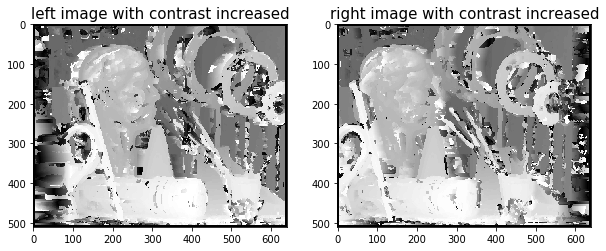

In [18]:

dl4_edit = my_format(dl4,9)

cv2.imwrite('ps2-3-b-0.jpg',dl4_edit)

dr4_edit =  my_format(dr4,9)

cv2.imwrite('ps2-3-b-1.jpg',dr4_edit)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(dl4,cmap='gray'),plt.title('left image with contrast increased',fontsize=15)
plt.subplot(1,2,2),plt.imshow(dr4,cmap='gray'),plt.title('right image with contrast increased',fontsize=15)
plt.show()

Changes of contrast don't seem to have as much impact as the noise. However, some objects disappeared such as the little bird figurine in the foreground.

### Question 4 :
#### a)

row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done


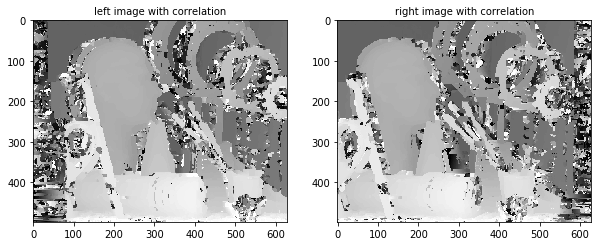

Wall time: 39.7 s


In [32]:
%%time
im_4_l = cv2.imread('./Data/proj2-pair1-L.png',0)
im_4_r = cv2.imread('./Data/proj2-pair1-R.png',0)

dl4_c = disparity(im_4_l,im_4_r,size=13,disparity = 95,matching='correlation')
dr4_c = disparity(im_4_r,im_4_l,size=13,disparity = 95,matching='correlation')

dl4_c_edit = my_format(dl4_c,13)
dr4_c_edit = my_format(dr4_c,13)

cv2.imwrite('ps2-4-a-0.jpg',dl4_c_edit)

cv2.imwrite('ps2-4-a-1.jpg',dr4_c_edit)


plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(dl4_c_edit,cmap='gray'),plt.title('left image with correlation',fontsize=10)
plt.subplot(1,2,2),plt.imshow(dr4_c_edit,cmap='gray'),plt.title('right image with correlation',fontsize=10)
plt.show()

The disparity images seem less accurate than the SSD version. Indeed, there is more noise and the little figurine in the foreground has almost disappeared.

In [30]:
%%time
im_4_l = cv2.imread('./Data/proj2-pair1-L.png',0)
im_4_r = cv2.imread('./Data/proj2-pair1-R.png',0)



im_4_l_n = addNoise(im_4_l)
im_4_r_n = addNoise(im_4_r)

size_c = 15

dl4_n = disparity(im_4_l,im_4_r_n,size=size_c,disparity = 95,matching='correlation')
dr4_n = disparity(im_4_r,im_4_l_n,size=size_c,disparity = 95,matching='correlation')
dl4_2n = disparity(im_4_l_n,im_4_r_n,size=size_c,disparity = 95,matching='correlation')
dr4_2n = disparity(im_4_r_n,im_4_l_n,size=size_c,disparity = 95,matching='correlation')




row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
Wall time: 1min 20s


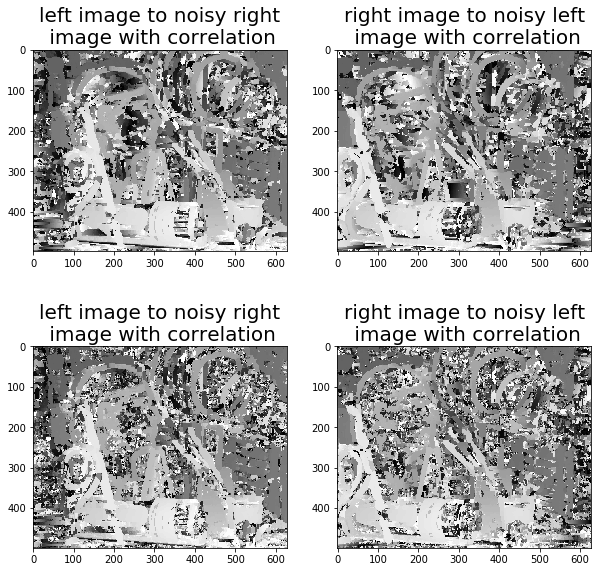

In [74]:

dl4_n_edit=my_format(dl4_n,size_c)

cv2.imwrite('ps2-4-b-0.jpg',dl4_n_edit)

dr4_n_edit=my_format(dr4_n,size_c)

cv2.imwrite('ps2-4-b-1.jpg',dr4_n_edit)

dl4_2n_edit=my_format(dl4_2n,size_c)

cv2.imwrite('ps2-4-b-2.jpg',dl4_2n_edit)

dr4_2n_edit=my_format(dr4_2n,size_c)

cv2.imwrite('ps2-4-b-3.jpg',dr4_2n_edit)



plt.figure(figsize=(10,10))
plt.subplot(2,2,1),plt.imshow(dl4_n_edit,cmap='gray'),plt.title('left image to noisy right\n image with correlation',fontsize=20)
plt.subplot(2,2,2),plt.imshow(dr4_n_edit,cmap='gray'),plt.title('right image to noisy left\n image with correlation',fontsize=20)
plt.subplot(2,2,3),plt.imshow(dl4_2n_edit,cmap='gray'),plt.title('left image to noisy right\n image with correlation',fontsize=20)
plt.subplot(2,2,4),plt.imshow(dr4_2n_edit,cmap='gray'),plt.title('right image to noisy left\n image with correlation',fontsize=20)
plt.show()

The correlation version seems to be more sensitive to noise since most of the shapes are modified in these disparity images.

row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done


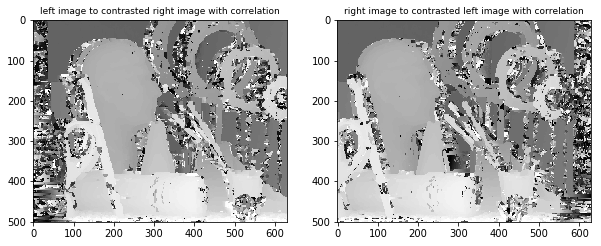

Wall time: 40.1 s


In [67]:
%%time
im_4_l = cv2.imread('./Data/proj2-pair1-L.png',0)
im_4_r = cv2.imread('./Data/proj2-pair1-R.png',0)


im_4_l_c = addContrast(im_4_l)
im_4_r_c = addContrast(im_4_r)

dl4_c = disparity(im_4_l,im_4_r_c,size=11,disparity = 95,matching='correlation')
dr4_c = disparity(im_4_r,im_4_l_c,size=11,disparity = 95,matching='correlation')


dl4_c_edit=my_format(dl4_c,11)

cv2.imwrite('ps2-4-b-4.jpg',dl4_c_edit)


dr4_c_edit=my_format(dr4_c,11)

cv2.imwrite('ps2-4-b-5.jpg',dr4_c_edit)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(dl4_c_edit,cmap='gray'),plt.title('left image to contrasted right image with correlation',fontsize=9)
plt.subplot(1,2,2),plt.imshow(dr4_c_edit,cmap='gray'),plt.title('right image to contrasted left image with correlation',fontsize=9)
plt.show()

The constrast does not have an important impact for the disparity computation. Indeed, we just multiply the intensity values of the pixels which does not affect the disparity.

### Question 5 :

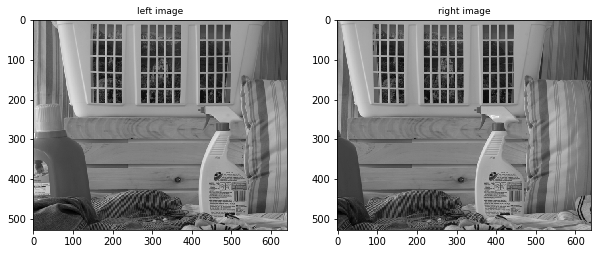

Wall time: 267 ms


In [55]:
%%time
im_5_l = cv2.imread('./Data/proj2-pair2-L.png',0)
im_5_r = cv2.imread('./Data/proj2-pair2-R.png',0)


plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(im_5_l,cmap='gray'),plt.title('left image',fontsize=9)
plt.subplot(1,2,2),plt.imshow(im_5_r,cmap='gray'),plt.title('right image',fontsize=9)
plt.show()

In [56]:
%%time
d5l_r_s = disparity(im_5_l,im_5_r,size=11,disparity = 90,matching='ssd')
d5r_l_s = disparity(im_5_r,im_5_l,size=11,disparity = 90,matching='ssd')

row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
Wall time: 13min 32s


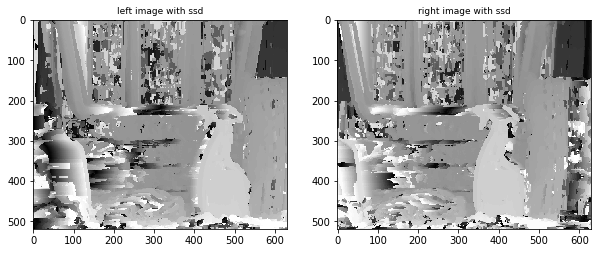

In [57]:
d5l_r_s_edit=my_format(d5l_r_s,11)

cv2.imwrite('ps2-5-a-0.jpg',d5l_r_s_edit)

d5r_l_s_edit=my_format(d5r_l_s,11)

cv2.imwrite('ps2-5-a-1.jpg',d5r_l_s_edit)


plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(d5l_r_s_edit,cmap='gray'),plt.title('left image with ssd',fontsize=9)
plt.subplot(1,2,2),plt.imshow(d5r_l_s_edit,cmap='gray'),plt.title('right image with ssd',fontsize=9)
plt.show()

In [58]:
d5l_r_c = disparity(im_5_l,im_5_r,size=11,disparity = 100,matching='correlation')
d5r_l_c = disparity(im_5_r,im_5_l,size=11,disparity = 100,matching='correlation')

row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done


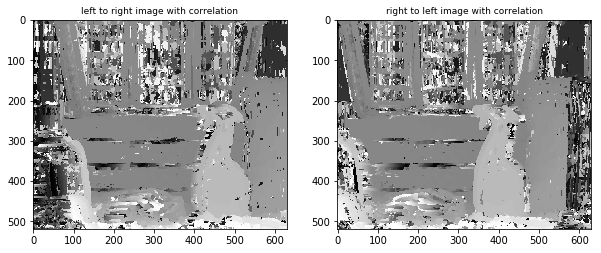

In [59]:

d5l_r_c_edit=my_format(d5l_r_c,11)

cv2.imwrite('ps2-5-a-2.jpg',d5l_r_c_edit)

d5r_l_c_edit=my_format(d5r_l_c,11)

cv2.imwrite('ps2-5-a-3.jpg',d5r_l_c_edit)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.imshow(d5l_r_c_edit,cmap='gray'),plt.title('left to right image with correlation',fontsize=9)
plt.subplot(1,2,2),plt.imshow(d5r_l_c_edit,cmap='gray'),plt.title('right to left image with correlation',fontsize=9)
plt.show()

In [62]:
%%time
im_blur_l = cv2.GaussianBlur(im_5_l,(5,5),0)
im_blur_r = cv2.GaussianBlur(im_5_r,(5,5),0)


d5l_r_s_b = disparity(im_5_l,im_blur_r,size=11,disparity = 100,matching='ssd')
d5r_l_s_b = disparity(im_5_r,im_blur_l,size=11,disparity = 100,matching='ssd')




row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done
Wall time: 15min 40s


In [63]:

d5l_r_s_b_edit=my_format(d5l_r_s_b ,11)

cv2.imwrite('ps2-5-a-4.jpg',d5l_r_s_b_edit)

d5r_l_s_b_edit=my_format(d5r_l_s_b,11)

cv2.imwrite('ps2-5-a-5.jpg',d5r_l_s_b_edit)

True

In [64]:
d5l_r_c_b = disparity(im_5_l,im_blur_r,size=15,disparity = 100,matching='correlation')
d5r_l_c_b = disparity(im_5_r,im_blur_l,size=15,disparity = 100,matching='correlation')


row :  100
row :  200
row :  300
row :  400
row :  500
process done
row :  100
row :  200
row :  300
row :  400
row :  500
process done


In [65]:
d5l_r_c_b_edit=my_format(d5l_r_c_b ,11)

cv2.imwrite('ps2-5-a-4.jpg',d5l_r_c_b_edit)

d5r_l_c_b_edit=my_format(d5r_l_c_b,11)

cv2.imwrite('ps2-5-a-5.jpg',d5r_l_s_b_edit)

True

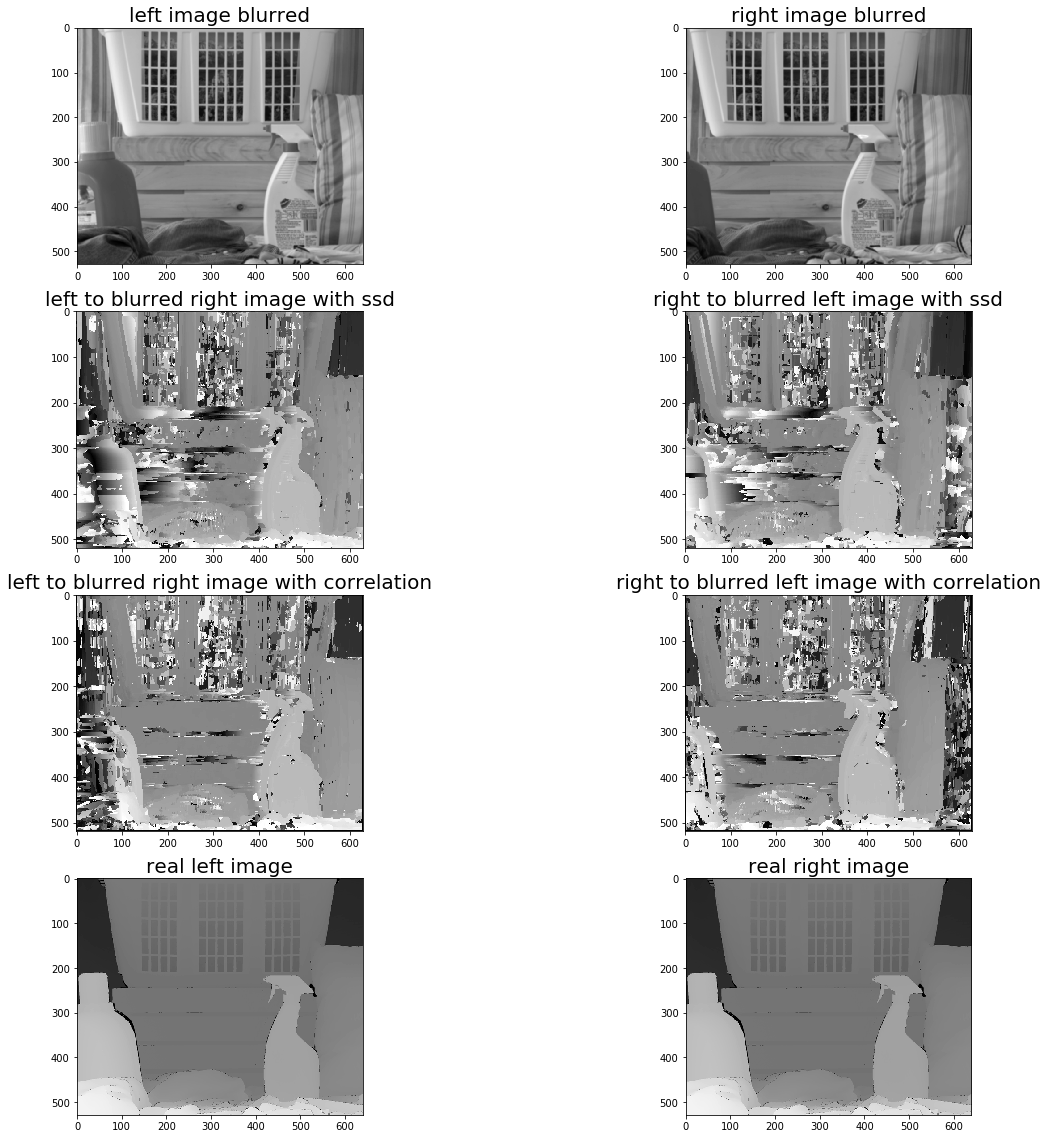

In [66]:
plt.figure(figsize=(20,20))
plt.subplot(4,2,1),plt.imshow(im_blur_l,cmap='gray'),plt.title('left image blurred',fontsize=20)
plt.subplot(4,2,2),plt.imshow(im_blur_r,cmap='gray'),plt.title('right image blurred',fontsize=20)
plt.subplot(4,2,3),plt.imshow(d5l_r_s_b_edit,cmap='gray'),plt.title('left to blurred right image with ssd',fontsize=20)
plt.subplot(4,2,4),plt.imshow(d5r_l_s_b_edit,cmap='gray'),plt.title('right to blurred left image with ssd',fontsize=20)
plt.subplot(4,2,5),plt.imshow(d5l_r_c_b_edit,cmap='gray'),plt.title('left to blurred right image with correlation',fontsize=20)
plt.subplot(4,2,6),plt.imshow(d5r_l_c_b_edit,cmap='gray'),plt.title('right to blurred left image with correlation',fontsize=20)
plt.subplot(4,2,7),plt.imshow(cv2.imread('./Data/proj2-pair2-Disp-L.png',0),cmap='gray'),plt.title('real left image',fontsize=20)
plt.subplot(4,2,8),plt.imshow(cv2.imread('./Data/proj2-pair2-Disp-L.png',0),cmap='gray'),plt.title('real right image',fontsize=20)

plt.show()

The keypoint to compute the right disparity image using a window-based method, is to find the good window size. If the window is too small then the disparity will be inaccurate because the ratio to noise will be low. On the other hand if the window is too big then the disparity will be smoother but we will loose some information about the shapes.

Furthermore, even if SSD seems more accurate than normalized cross correlation, cross correlation is faster. Hence, some applications requiring fast computation might prefere cross correlation to SSD to compute the disparity.